https://pytorch.org/tutorials/beginner/nn_tutorial.html

incomplete

In [2]:
import os

In [3]:
os.environ['CUDA_VISIBLE_DEVICES']

'0'

In [1]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [5]:
PATH

PosixPath('data/mnist')

In [6]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


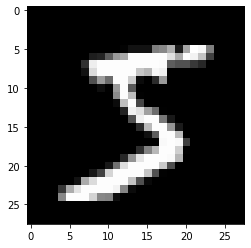

In [7]:
from matplotlib import pyplot
%matplotlib inline
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

In [10]:
import torch

In [11]:
# map to cuda memory

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


# Neural net from scratch (no torch.nn)

In [12]:
import math

# f(w,x)
# we create w and x below with gradient required for backprop, tensor by default are not enabled with gradient tracking
weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)


So let’s just write a plain matrix multiplication and broadcasted addition to create a simple linear model. We also need an activation function, so we’ll write log_softmax and use it

In [17]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

#the @ stands for the dot product operation

In [18]:
# Example of one forward pass

bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.7179, -2.3276, -2.4967, -2.2036, -2.5525, -2.7263, -1.9191, -2.3800,
        -2.6211, -1.6695], grad_fn=<SelectBackward>) torch.Size([64, 10])


In [19]:
# Let’s implement negative log-likelihood to use as the loss function (again, we can just use standard Python):

def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [20]:
# loss of the forward pass
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3261, grad_fn=<NegBackward>)


In [21]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [22]:
print(accuracy(preds, yb))

tensor(0.1719)


We can now run a training loop. For each iteration, we will:

* select a mini-batch of data (of size bs)
* use the model to make predictions
* calculate the loss
* loss.backward() updates the gradients of the model, in this case, weights and bias.

In [35]:
lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        #         set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        if i % 100 == 0:
            print("Training", "e:", epoch, "/", i, ", loss:", loss.item())

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()
            

Training e: 0 / 0 , loss: 0.15022413432598114
Training e: 0 / 100 , loss: 0.25271663069725037
Training e: 0 / 200 , loss: 0.1553950011730194
Training e: 0 / 300 , loss: 0.2936423420906067
Training e: 0 / 400 , loss: 0.18183283507823944
Training e: 0 / 500 , loss: 0.3085951805114746
Training e: 0 / 600 , loss: 0.17237237095832825
Training e: 0 / 700 , loss: 0.31980669498443604
Training e: 1 / 0 , loss: 0.14915454387664795
Training e: 1 / 100 , loss: 0.25181010365486145
Training e: 1 / 200 , loss: 0.15487223863601685
Training e: 1 / 300 , loss: 0.29309898614883423
Training e: 1 / 400 , loss: 0.1817362755537033
Training e: 1 / 500 , loss: 0.30742955207824707
Training e: 1 / 600 , loss: 0.17127616703510284
Training e: 1 / 700 , loss: 0.3186821937561035


In [36]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0507, grad_fn=<NegBackward>) tensor(1.)


# Using torch.nn.functional

In [39]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

In [40]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0507, grad_fn=<NllLossBackward>) tensor(1.)


In [41]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

In [42]:
model = Mnist_Logistic()

In [43]:
print(loss_func(model(xb), yb))

tensor(2.3153, grad_fn=<NllLossBackward>)


In [44]:
with torch.no_grad():
    weights -= weights.grad * lr
    bias -= bias.grad * lr
    weights.grad.zero_()
    bias.grad.zero_()

In [46]:
# with torch.no_grad():
#     for p in model.parameters(): p -= p.grad * lr
#     model.zero_grad()

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

In [47]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

In [48]:
print(loss_func(model(xb), yb))


tensor(0.0822, grad_fn=<NllLossBackward>)
